In [1]:
# Modules to import
import argparse
import os
import pandas as pd
import scipy.stats
from simtk.unit import *
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy.optimize import curve_fit
from openmmtools.constants import STANDARD_STATE_VOLUME
from tqdm import tqdm

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
scipy.__version__

'1.11.4'

In [3]:
def calc_VGCMC(radius):
    V = 4 / 3 * np.pi * radius**3
    return V


def calc_LigVol(conc):
    V_l = 1 / (AVOGADRO_CONSTANT_NA * conc)
    return V_l.in_units_of(angstroms**3)


def calc_c_from_B(B, HFE, sphere_rad):
    c = np.exp(B - (beta * HFE)) / (AVOGADRO_CONSTANT_NA * calc_VGCMC(sphere_rad))
    return c.in_units_of(molar)


def calcB(HFE, sphere_rad, V_L):
    test = calc_VGCMC(sphere_rad) / (V_L)
    B = (beta * HFE) + np.log(test)
    return B


def sigmoid(x, x0, k):
    """
    1 / 1 + exp(-k(B-betadF))
    Parameters
    ----------
    x
    x0
    k

    Returns
    -------

    """
    y = 1 / (1 + np.exp(-k * (x - x0)))
    return y

rad = 8 * angstrom
T = 298 * kelvin
kT = (BOLTZMANN_CONSTANT_kB * T * AVOGADRO_CONSTANT_NA).in_units_of(
    kilocalories_per_mole
)
beta = 1 / kT


def gen_text(mean_B50, sem_B50, dF_trans, dF_trans_err, dG):
    return r"$B_{{50}} = \beta \Delta F_{{trans}} = {:.1f} \pm {:.1f}$".format(
        mean_B50, sem_B50
    ) + "\n" + r"$\Delta F_{{trans}} = {:.1f} \pm {:.1f}\ kcal\ mol^{{-1}}$".format(
        dF_trans._value, dF_trans_err._value
    ) + "\n" r"$\Delta G^{{o}}_{{bind}} = \Delta F_{{trans}} + \Delta F_{{ideal}} - \Delta G_{{sol}}$" + "\n" + r"$\Delta G^{{o}}_{{bind}} = {:.1f} \pm {:.1f}\ kcal\ mol^{{-1}}$".format(
        dG._value, dF_trans_err._value
    )

In [151]:
mu_df = pd.read_csv(
    "/home/will/data_6/LIG_GCNCMC_PAPER/REVIEW_ANALYSIS/titrations/Mu_ex.txt",
    converters={"Name": str},
)

ligands = mu_df["Name"].to_list()
ligands = ["Thianaphthene"]
for lig in ligands:
    mu_ex = mu_df[mu_df["Name"] == lig]["Mu_Ex"].values[0] * kilocalories_per_mole
    Bs = np.load(
        f"/home/will/data_6/LIG_GCNCMC_PAPER/REVIEW_ANALYSIS/TIT_CONVER/{lig}_B_values.npy"
    )
    full_data = np.load(
        f"/home/will/data_6/LIG_GCNCMC_PAPER/REVIEW_ANALYSIS/TIT_CONVER/{lig}_full_data.npy"
    )

    full_data[full_data[:, :, :] > 1] = 1  # Bring data to N_max = 1
    occs = full_data[:, -1, :]

In [152]:
occs

array([[0.   ,   nan,   nan,   nan,   nan],
       [0.   ,   nan,   nan,   nan,   nan],
       [0.   , 0.   , 0.   , 0.002, 0.003],
       [0.   ,   nan,   nan,   nan,   nan],
       [0.   ,   nan,   nan,   nan,   nan],
       [0.003,   nan,   nan,   nan,   nan],
       [0.003,   nan,   nan,   nan,   nan],
       [0.004,   nan,   nan,   nan,   nan],
       [0.008,   nan,   nan,   nan,   nan],
       [0.054,   nan,   nan,   nan,   nan],
       [  nan, 0.   , 0.003, 0.044, 0.   ],
       [0.   ,   nan,   nan,   nan,   nan],
       [  nan, 0.   , 0.001, 0.   , 0.019],
       [0.005,   nan,   nan,   nan,   nan],
       [0.001,   nan,   nan,   nan,   nan],
       [  nan, 0.085, 0.   , 0.   , 0.022],
       [0.   ,   nan,   nan,   nan,   nan],
       [  nan, 0.048, 0.073, 0.025, 0.005],
       [0.   ,   nan,   nan,   nan,   nan],
       [0.   ,   nan,   nan,   nan,   nan],
       [  nan, 0.027, 0.013, 0.029, 0.002],
       [0.077,   nan,   nan,   nan,   nan],
       [  nan, 0.   , 0.114, 0.0

In [78]:
def fit_curve(Bs, occs, mu_ex, rad, beta=beta):
    params = []
    Nbs, Nrs = occs.shape
    for r in range(Nrs):
        initial_guess = [np.median(Bs), 1]
        occ_list = occs[:, r]
        Bs_filtered = Bs
        occ_list_filtered = occ_list
        popt, pcov = curve_fit(
            sigmoid, Bs_filtered, occ_list_filtered, p0=initial_guess, maxfev=10000, nan_policy='omit'
        )
        params.append(popt)

    mean_B50 = np.mean(params, axis=0)[0]
    sem_B50 = np.std(params, axis=0)[0] / np.sqrt(len(params))

    dF_trans = (mean_B50 / beta).in_units_of(kilocalories_per_mole)
    dF_trans_err = sem_B50 * kilocalories_per_mole

    dG = kT * np.log(calc_c_from_B(mean_B50, mu_ex, rad))
    dG_err = kT * np.log(calc_c_from_B(mean_B50 + sem_B50, mu_ex, rad))
    return params, mean_B50, sem_B50, dF_trans, dF_trans_err, dG, dG_err

In [175]:
def inverse_sigmoid(Y, x0, k):
    return (-np.log((1 - Y) / Y) / k) + x0


def generate_bootstrap_data(n, occupancies, Bs):
    # Generate lots of randome occupancy samples

    Nbs, Nrs = occupancies.shape
    bootstrap_data = np.zeros((Nbs, n))
    for i in tqdm(range(Nbs)):
        for j in range(n):
            rand_repeat_id = np.random.randint(0, Nrs)
            # while np.isnan(occupancies[i][rand_repeat_id]):
            #     rand_repeat_id = np.random.randint(0, Nrs)
            bootstrap_data[i][j] = occupancies[i][rand_repeat_id]

    return bootstrap_data


def plot_mean_curve(Bs, occs, ax, title):
    B_fit = np.linspace(min(Bs), max(Bs), 500)
    N_fit_all = []
    tau = scipy.stats.kendalltau(Bs, np.nanmean(occs, axis=1), nan_policy="omit")[0]
    params, mean_B50, sem_B50, dF_trans, dF_trans_err, dG, dG_err = fit_curve(Bs, occs, mu_ex, rad)

    # Calculate non fitted curves
    fit = []
    mean_params = np.mean(params, axis=0)
    sem_params = np.std(params, axis=0) / np.sqrt(len(params))
    for p in params:
        fit.append(sigmoid(Bs, *p))

    # Calculate fitted curves
    for p in params:
        N_fit = sigmoid(B_fit, *p)
        N_fit_all.append(N_fit)

    # Plot raw data
    Nbs, Nrs = occs.shape
    plotted_legend = False
    for r in range(Nrs):
        occ_list = occs[:, r]
        if not plotted_legend:
            ax.plot(
                Bs,
                occ_list,
                marker="x",
                linestyle="None",
                c="black",
                label="Raw data " + r"($\tau={:.3f}$)".format(tau),
            )
            plotted_legend = True
        else:
            ax.plot(Bs, occ_list, marker="x", linestyle="None", c="black")

    N_fit_mean = np.mean(fit, axis=0)
    N_fit_SEM = np.std(fit, axis=0) / np.sqrt(len(fit))
    N_fit_mean = sigmoid(Bs, *mean_params)
    N_fit_SEM = sigmoid(Bs, *(mean_params+sem_params))

    # np.std(fit, axis=0)[0] / np.sqrt(len(fit))

    B_fit = Bs
    tau_fit = scipy.stats.kendalltau(Bs, N_fit_mean, nan_policy="omit")[0]
    ax.plot(
        B_fit,
        N_fit_mean,
        "-",
        color="#04e762",
        label="Mean Fit" + r" ($\tau={:.3f}$)".format(tau_fit),
    )
    ax.fill_between(
        B_fit,
        sigmoid(Bs, *(mean_params-sem_params)),
        sigmoid(Bs, *(mean_params + sem_params)),
        alpha=0.5,
        lw=0,
        color="#000080",
    )

    # x50 = [mean_B50, mean_B50]
    # y50 = [0, 0.5]
    y_vline = sigmoid(mean_B50, *np.mean(params, axis=0))
    print("y_vline", y_vline)

    ax.vlines(mean_B50, 0, y_vline, linestyle="--", color="k") 
    # ax.plot(x50, y50, linestyle="--", c="k")

    # Add the text at the bottom right
    ax.text(
        0.98,
        0.05,
        gen_text(mean_B50, sem_B50, dF_trans, dF_trans_err, dG),
        transform=ax.transAxes,
        verticalalignment="bottom",
        horizontalalignment="right",
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.8),
    )
    ax.set_title(title)
    ax.set_xlabel("Adams value, $B$")
    ax.set_ylabel(r"Average N")
    ax.legend(loc="upper left")

In [156]:
np.nanmean(occs, axis=1)

array([0.     , 0.     , 0.001  , 0.     , 0.     , 0.003  , 0.003  ,
       0.004  , 0.008  , 0.054  , 0.01175, 0.     , 0.005  , 0.005  ,
       0.001  , 0.02675, 0.     , 0.03775, 0.     , 0.     , 0.01775,
       0.077  , 0.04125, 0.143  , 0.15825, 0.16625, 0.2884 , 0.34875,
       0.4725 , 0.026  , 0.45275, 0.745  , 0.84225, 0.83075, 0.77825,
       0.784  , 0.946  , 0.975  ])

In [136]:
bootoccs = generate_bootstrap_data(5000, occs, Bs)

100%|██████████| 20/20 [00:00<00:00, 81.66it/s]


In [137]:
bootoccs

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.958, 0.955, 0.955, ..., 0.958, 0.739, 0.955],
       [0.978, 1.   , 1.   , ..., 1.   , 1.   , 1.   ],
       [  nan, 1.   , 1.   , ..., 1.   , 1.   , 1.   ]])

In [138]:
occs

array([[0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   ,   nan],
       [0.   , 0.002, 0.   ,   nan],
       [0.   , 0.   , 0.003, 0.   ],
       [0.   , 0.   , 0.   ,   nan],
       [0.   , 0.001, 0.   , 0.   ],
       [0.006, 0.003, 0.009, 0.   ],
       [0.01 , 0.063, 0.   ,   nan],
       [0.006, 0.032, 0.117, 0.007],
       [0.033, 0.013, 0.04 , 0.001],
       [0.341, 0.063, 0.026, 0.02 ],
       [0.142, 0.21 , 0.066, 0.194],
       [0.619, 0.195, 0.171, 0.413],
       [0.712, 0.633, 0.763, 0.98 ],
       [0.955, 0.869, 0.739, 0.958],
       [1.   , 1.   , 0.978, 1.   ],
       [1.   , 1.   , 1.   ,   nan]])

In [139]:
occs
params, mean_B50, sem_B50, dF_trans, dF_trans_err, dG, dG_err = fit_curve(
    Bs, occs, mu_ex, rad
)


In [169]:
len(params)

4

In [172]:
np.mean(params, axis=0) + np.std(params, axis=0) / np.sqrt(len(params))

array([-7.68781355,  2.87642715])

In [140]:
mean_B50

-7.824765147600015

In [141]:
full_data[:, -1, :]

array([[0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   ,   nan],
       [0.   , 0.002, 0.   ,   nan],
       [0.   , 0.   , 0.003, 0.   ],
       [0.   , 0.   , 0.   ,   nan],
       [0.   , 0.001, 0.   , 0.   ],
       [0.006, 0.003, 0.009, 0.   ],
       [0.01 , 0.063, 0.   ,   nan],
       [0.006, 0.032, 0.117, 0.007],
       [0.033, 0.013, 0.04 , 0.001],
       [0.341, 0.063, 0.026, 0.02 ],
       [0.142, 0.21 , 0.066, 0.194],
       [0.619, 0.195, 0.171, 0.413],
       [0.712, 0.633, 0.763, 0.98 ],
       [0.955, 0.869, 0.739, 0.958],
       [1.   , 1.   , 0.978, 1.   ],
       [1.   , 1.   , 1.   ,   nan]])

In [142]:
occs

array([[0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   ,   nan],
       [0.   , 0.002, 0.   ,   nan],
       [0.   , 0.   , 0.003, 0.   ],
       [0.   , 0.   , 0.   ,   nan],
       [0.   , 0.001, 0.   , 0.   ],
       [0.006, 0.003, 0.009, 0.   ],
       [0.01 , 0.063, 0.   ,   nan],
       [0.006, 0.032, 0.117, 0.007],
       [0.033, 0.013, 0.04 , 0.001],
       [0.341, 0.063, 0.026, 0.02 ],
       [0.142, 0.21 , 0.066, 0.194],
       [0.619, 0.195, 0.171, 0.413],
       [0.712, 0.633, 0.763, 0.98 ],
       [0.955, 0.869, 0.739, 0.958],
       [1.   , 1.   , 0.978, 1.   ],
       [1.   , 1.   , 1.   ,   nan]])

In [143]:
mean_B50

-7.824765147600015

In [144]:
b50s = [0]
sems = [0]
# convergance bits
steps = np.arange(100, 1600, 100)
for step in steps:
    step_data = full_data[:, step-1, :]
    params, mean_B50, sem_B50, dF_trans, dF_trans_err, dG, dG_err = fit_curve(
        Bs, step_data, mu_ex, rad
    )
    b50s.append(mean_B50)
    sems.append(sem_B50)

In [145]:
b50s

[0,
 -7.3418911753293745,
 -7.23663378322887,
 -7.377028609810097,
 -7.4410617056895525,
 -7.480421872594597,
 -7.433916408457332,
 -7.498774025043041,
 -7.5820841093559945,
 -7.610669859752482,
 -7.61168801857572,
 -7.664928125357104,
 -7.70218228028703,
 -7.800265367784474,
 -7.800146328501322,
 -7.824765147600015]

In [146]:
def plot_convergance(steps, b50s, sems, ax):
    ax.errorbar(
        steps,
        b50s[1:],
        yerr=sems[1:],
        fmt="o",
        ecolor='r',
        markersize=10,
        markeredgewidth=3,
        markerfacecolor="white",
        markeredgecolor="red",
        linestyle="none",
        elinewidth=2
    )
    # ax.plot(steps, b50s[1:], marker="o", linestyle="None", mfc="none", ms=10, c='r')
    # Plot the line connecting the data points
    ax.plot(steps, b50s[1:], ls="-", label="Fit line", lw=2, c='r')
    ax.fill_between(steps, b50s[-1] - sems[-1], b50s[-1] + sems[-1], color='gray', alpha=0.2)

    # Add labels and legend
    ax.set_xlabel("Number of GCNCMC Moves")
    ax.set_ylabel("B50")

y_vline 0.5


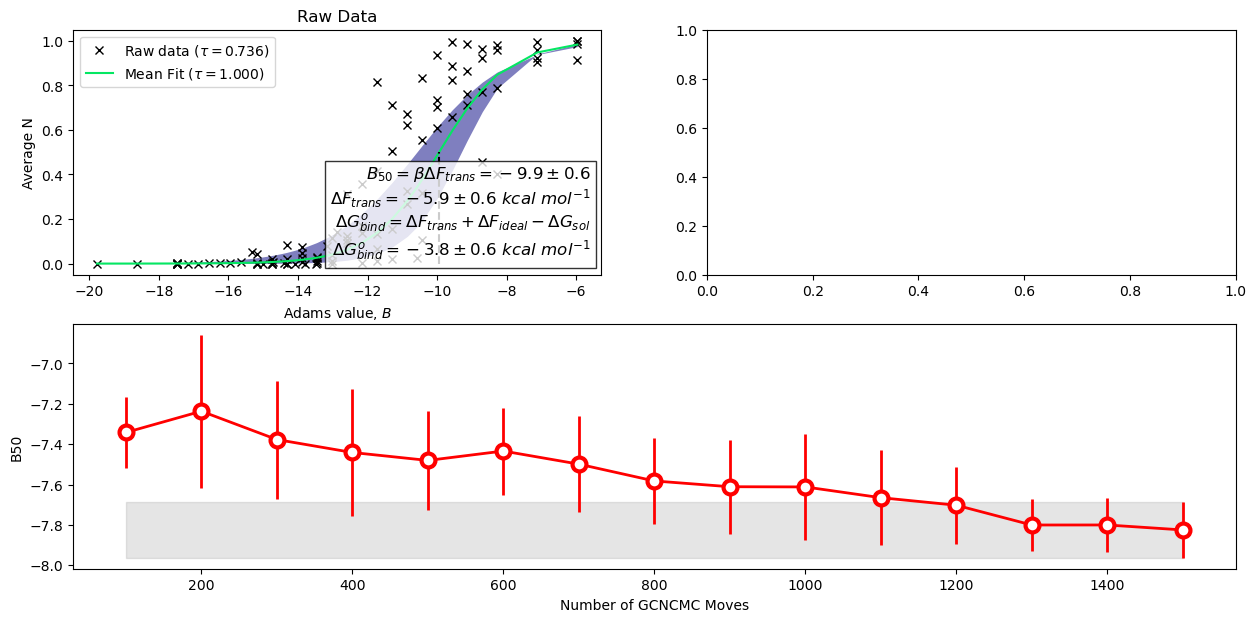

In [176]:
fig = plt.figure(figsize=(15, 7))
axes = fig.subplot_mosaic(
    """AB
                             CC"""
)  # Raw, Booted, Convergance

plot_mean_curve(Bs, occs, axes["A"], "Raw Data")
#bootoccs = generate_bootstrap_data(5000, occs, Bs)
#plot_mean_curve(Bs, bootoccs, axes["B"], "Bootstrapped")
plot_convergance(steps, b50s, sems, axes["C"])

In [15]:
Bs.shape

(20,)

In [16]:
Bs

array([-21.3117549 , -19.0091698 , -16.70658471, -14.40399962,
       -13.6955119 , -12.98702418, -12.27853646, -11.57004874,
       -10.86156101, -10.15307329,  -9.44458557,  -8.73609785,
        -8.02761013,  -7.31912241,  -6.61063469,  -5.90214697,
        -5.19365925,  -2.89107415,  -0.58848906,   1.71409603])

In [39]:
full_data


array([[[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        ...,
        [ 0., nan,  0.,  0.],
        [ 0., nan,  0.,  0.],
        [ 0., nan,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        ...,
        [ 0., nan,  0.,  0.],
        [ 0., nan,  0.,  0.],
        [ 0., nan,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        ...,
        [nan,  0.,  0.,  0.],
        [nan,  0.,  0.,  0.],
        [nan,  0.,  0.,  0.]],

       ...,

       [[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        ...,
        [nan,  1., nan, nan],
        [nan,  1., nan, nan],
        [nan,  1., nan, nan]],

       [[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        ...,
        [nan,  1., nan, nan],
        [nan,  1., nan, nan],
        [nan,  1., nan, nan]],

       [[ 1.

IndexError: boolean index did not match indexed array along dimension 0; dimension is 20 but corresponding boolean dimension is 1500